# Packets Ananlysis

## Description About Notebook

This Notebook Analyzes packets captured from Host Machines or Endpoints and Perform analysis on their respective pcap file's. <br>
By analzing DNS Packets within pcap's, able to lead to Human Interpretation. Where one can easily gather about likes and consumption duration. <br>
Such as the Host Machine User Watched Netlfix[dot]com for about 150 seconds or other such websites and time spent on them. <br>
No just this but also Which Website is on top, Maximum visits count, Avergae spent time and more... <br>

#### Note : Packets are captured in milli-seconds,but for Human interpretation results are presented in seconds
#### Note : So, least spent time always be 0 seconds or say in range (1 to 10000) mill-seconds

## NoteBook Flow

This Flow represents General Setting of Whole Notebook and Process undertaken leading to end result Ananlysis and Profile Comparisons.<br>
Here block-type-structures are used to represent the flow and details of each block if applicable is represented beneath/within the desired cell body.<br>

<img src="images_in/ProjectFlow.png"/>


In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

import subprocess
from os.path import isfile
from os.path import join as pjoin
from os import walk

import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.backends.backend_pdf import PdfPages
import numpy as np
import pandas as pd

from re import findall
from collections import defaultdict 

from wordcloud import WordCloud
from prettytable import PrettyTable
from fpdf import FPDF
from PIL import Image
from PyPDF2 import PdfFileMerger
#from PDFWriter import PDFWriter


In [2]:
# various dictionaries used to store profile info's
records = {}
rcr = {}
name_count = {}
domain_types_count = {}
stats = defaultdict()

#containers for holding all profiles info
profiles = {}
profile_count = 0
profile_cmprd = defaultdict()

#bash or os command
ip_command = 'tshark -r {} -Y "{}.addr=={}" -w -| {}'
capinfos_command = 'capinfos -r - -T -m -u -r'

#images list
images_names_list = ['_pie_chart.png','_hist.png','_barh_graph.png','_word_cloud.png','_vc_barh_graph.png']


In [3]:
def polished_qry_name(qry_name):
    
    """
       This Function converts not-human-friendly domain names into human-friendly domain names for simplyfing interpretation i.e abcd.gbcd.akagie.com to akagie.com
        ,by applying simple list comprehension and string splti func() 
       
       :param qry_name: not-human-friendly-domain-name
       
       :return: Human Friendly ease to interpretate domain name
    """
    
    
    dt = qry_name[::-1].split('.')[0][::-1]
    name = qry_name[::-1].split('.')[1][::-1]
    
    if domain_types_count.get(dt,-1) == -1: 
        domain_types_count[dt] = 0
    else:
        domain_types_count[dt] += 1
    if name_count.get(name,-1) == -1:
        name_count[name] = 0
    else:
        name_count[name] +=1
    
    return name+'.'+dt

In [4]:

def polished_dns_qry_name_col(testA):
    """
    This function calls another func() dns_ary_name and passes domain names from DataFrame
    
    :param testA: pandas DataFrame i.e. collection of series
    
    :return: DataFrame with changes into dns packets queries back to original DataFrame
    """
    modified = pd.DataFrame()
    modified['dns.qry.name'] = testA['dns.qry.name'].apply(polished_qry_name)
    return modified

In [5]:
def duration_capinfos(a):
    """
    This function filters the floating point value from a string by using regex findall func() i.e. b'abcidd 123.4455 skd' to 123.4455
    
    :param a: bytes data-type-variable represented as b'gibbersish'
    
    :return: floating-point value without rounding-off
    """
    a = str(a)
    x = [float(s) for s in findall(r'-?\d+\.?\d*', a)]
    if len(x)!=0:
        return x[0]
    return float(0.0)
    

## Inital or Point of Start

<br> 
<img src="images_in/tshark.png" />

In [6]:
def call_tshark(path_to_file):
    
    """
    This function is used to gather csv i.e comma separated values files (temporarily) for each pcap file as dns-queries, dns-responses, dns-init.
    Here Wireshark Utility i.e tshark is used to get desired fields from each packet by using Display Filter and Output Filters.
    Display Filters and Output Filters varies on the basis of end csv file.
    b'0x00000100' display filter for dns-queries-filtering
    b'0x00008180' output filter for dns-queries-responses
    
    It makes use of os-subprocess module for executing commands in bash directly using tshark.
    
    :param path_to_file: pcap file path from which export temporary csv's files
    :return: None
    
    """
    
    out = '/home/bajaj-debian/networkTrafficAnalysis/nta/csvs_out/'
    
    cmnd_dns_qry = 'tshark -r {} -Y "dns.flags==0x00000100" -T fields -e udp.stream -e frame.number -e dns.id -e dns.qry.name -e dns.qry.type -E occurrence=a -E aggregator=";" -E header=y -E separator=, > {}/dns_qry.csv '
    cmnd_dns_resp = 'tshark -r {} -Y "dns.flags==0x00008180" -T fields -e udp.stream -e frame.number -e dns.id -e dns.qry.name -e dns.resp.name -e dns.resp.type -e dns.a -e dns.aaaa -E header=y -E occurrence=a -E aggregator=";" -E separator=, > {}/dns_resp.csv'
    cmnd_dns_init = 'tshark -r {} -Y "dns.flags==0x00000100" -T fields -e udp.stream -e dns.id -e dns.qry.name -E header=y -E occurrence=a -E aggregator=";" -E separator=, > {}/dns_init.csv'
    
    tshark_command1 = cmnd_dns_qry.format(path_to_file,out)
    tshark_command2 = cmnd_dns_resp.format(path_to_file,out)
    tshark_command3 = cmnd_dns_init.format(path_to_file,out)
    
    if isfile(path_to_file):
        
        prcss1 = subprocess.run(tshark_command1,stdout=subprocess.PIPE,stderr=subprocess.STDOUT,
                        shell=True,check=False)
        prcss2 = subprocess.run(tshark_command2,stdout=subprocess.PIPE,stderr=subprocess.STDOUT,
                        shell=True,check=False)
        prcss3 = subprocess.run(tshark_command3,stdout=subprocess.PIPE,stderr=subprocess.STDOUT,
                        shell=True,check=False)
        
        if prcss1.returncode != 0:
            print("Error@1",prcss1.stderr)
        if prcss2.returncode != 0:
            print("Error@2",prcss2.stderr)
        if prcss3.returncode != 0:
            print("Error@3",prcss3.stderr)
        
    else:
        print("File Not Found!!!",end="\n\n")
   
        

## Read csv files generated
<br> 
<img src="images_in/read_csv.png" />

In [7]:
def read_csvs(path_to_file):
    
    """
    This function is used to read csv files of current-context-pcap file
    :param path_to_file: path of the file from where to read pcap file
    :return: Three DataFrames First dns-queries-df Second dns-responses-df Third dns-init=-df
    """
    
    out = '/home/bajaj-debian/networkTrafficAnalysis/nta/csvs_out/'
    
    ## Making csv_text_files
    ## 1. dns_Queries 2. dns_Responses 3. dns_results_filterization csv's
    df_dns_qry = pd.read_csv("{}/dns_qry.csv".format(out))
    df_dns_resp = pd.read_csv("{}/dns_resp.csv".format(out))
    df_dns_init = pd.read_csv("{}/dns_init.csv".format(out))
    
    ## Casting into object types
    df_dns_init = df_dns_init.astype(object)
    df_dns_qry = df_dns_qry.astype(object)
    df_dns_resp = df_dns_resp.astype(object)
    
    return df_dns_qry,df_dns_resp,df_dns_init
    

## Get Duration of Conversation
<br> 
<img src="images_in/get_duration.png"/>

In [8]:
def get_time_spent(path_to_file,df_test,ip_type):
    
    """
    This function is used to get duration of conversation of each ip address inside packet whether ipv4 or ipv6 and then append to pcap csv
    It makes use of wireshark utility i.e tshark and capinfos. At First tshark is used to filter the packets invloving the ip_addr and then
    capinfos is used to get duration of conversation to/from with ip_addr and end-user-ip_addr.
    To Achieve this os-path-isfile and os-subprocess module is used to execute commands in bash.
    This appends results i.e pcap csv dns-qry-name ip_addr and duration to dictionary data_structure temporary, which gets overwrite during Profile Creation
    
    :param path_to_file: It gives the path where pcap file is stored
    :param df_test: DataFrame of pcap, csv-appended
    :param ip_type: Used to get whether ip is of type version v4 or v6, This is done as ipv4 :: ip_type = 0 or ipv6 :: ip_type = 1
    
    :return: None
    """    
    
    if ip_type == 0:
        ip_res = 'ip'
    else:
        ip_res = 'ipv6'
        
    if isfile(path_to_file):
        
        for index,row in df_test.iterrows():
            name = row['dns.qry.name']
            ip   = row['dns.ip']
            
            lst = ip.split(';')
            
            for ipx in lst:
                
                tshark_command = ip_command.format(path_to_file,ip_res,ipx,capinfos_command)
                
                prcss = subprocess.run(tshark_command,stdout=subprocess.PIPE,stderr=subprocess.STDOUT,
                        shell=True,check=False)
                egz = prcss.stdout
           
                egz = duration_capinfos(egz) 
            
                if egz == 0:
                    pass
                else:

                    if records.get(profile_count,-1) == -1:
                        records[name] = round(egz,2)
                        rcr[name] = [egz]
                    else:
                        records[name] += round(egz,2)
                        rcr[name].append(egz)
                        
                if prcss.returncode !=0:
                    print("\n STDERR::"+" "+p1.stderr,end="\n")
    else:
        print("File Not Found!!!",end="\n\n")
    

        
    

##  Classification as version 4 or 6 DataFrames

<br>
<img src="images_in/ip_classification.png" />

In [9]:
def get_two_factored_ips_frames(df_dns_qry,df_dns_resp,df_dns_init):
    
    """
    This Function is used for ip_addr classifications into ipv4 and ipv6 DataFrames.
    It makes uses of pandas deep copy function to aut0-migrate on changes from inital source to all copies or view of DataFrame.
    The inital responses-dataframe is filter or drop-down to ipv4 and ipv6 dataframes. 
    Then the NAN values rows are drop thereafter duplicated rows are removed.
    Thereafter DataFrame sorted according to a column and rename to one-common-column-name in dataframes for later ip dataframes merging.
    
    :param df_dns_qry: DataFrame 
    :param df_dns_resp: DataFrame 
    :param df_dns_init: DataFrame
    
    :return: Two DataFrames testA and testB one is of ipv4 DataFrame and another ipv6 DataFrame
    
    """
    
    ## Brute Force Approcach and Examining
    df_dns_resp_2 = df_dns_resp.copy(deep=True)
    df_dns_resp_2 = df_dns_resp_2[['dns.id','dns.qry.name','dns.a','dns.aaaa','dns.resp.name']]
    #case-1
    df_dns_resp_2A = df_dns_resp_2.copy(deep=True)
    df_dns_resp_2A = df_dns_resp_2A[['dns.qry.name','dns.a']]
    #case-2
    df_dns_resp_2B = df_dns_resp_2.copy(deep=True)
    df_dns_resp_2B = df_dns_resp_2B[['dns.qry.name','dns.aaaa']]
    #drop_karo_na
    df_dns_resp_2A.dropna(inplace=True)
    df_dns_resp_2B.dropna(inplace=True)
    
    ## Brute Force Approach and Filtering
    testA = df_dns_resp_2A.copy(deep=True)
    testB = df_dns_resp_2B.copy(deep=True)
    ##polishing queries to stdr..
    testA['dns.qry.name'] = polished_dns_qry_name_col(testA)
    testB['dns.qry.name'] = polished_dns_qry_name_col(testB)
    df_dns_init['dns.qry.name'] = polished_dns_qry_name_col(df_dns_init)
    ## Droping Duplicate Rows and Sorting Alphabetically
    #remove_dups
    testA.drop_duplicates(inplace=True)
    testB.drop_duplicates(inplace=True)
    #sort
    testA.sort_values(by='dns.qry.name',inplace=True)
    testB.sort_values(by='dns.qry.name',inplace=True)
    #renaming columns
    testA.rename(columns={'dns.a':'dns.ip'},inplace=True)
    testB.rename(columns={'dns.aaaa':'dns.ip'},inplace=True)
    
    return testA,testB

    

In [10]:
def get_max_time_spent_website(dct,val):
    """
        This Function returns the dns-query-name out of provided dictionary-data-structure,by making use of simple O(1) search i.e Hashing
        :param dct: dictionary-data-structure using hashing to search in O(1)
        :param val: Value to Searched in dictionary
        :return: website-name with maximum duration in pcap file 
    """
    for k in dct.keys():
        if dct[k] == val:
            return k
    return 'Not Found'


In [11]:
def get_df_from_records(records):
    """
    This function is used to convert dicitonary-data-structure to DataFrame
    :param records: dictionary-data-structure
    :return: DataFrame based on index-based-columns-orientation
    """
    return pd.DataFrame.from_dict(
        records,orient='index',columns=['dns.time.spent']
    )
    


In [12]:
def plot_pie_chart(df_test_records):
    """
    This Function is used to plot pie chart which shows share of each web-query made for how many time and duration in seconds
    It uses pandas DataFrame to do so
    
    :parm: pcap file dataframe containing useful inforamtion
    
    :return: None
    """
    
    fig, ax = plt.subplots()
    df_test_records.plot(ax=ax,kind="pie",subplots=True,fontsize=18,legend=False)
    fig.savefig('images_out/'+str(profile_count)+'_pie_chart.png',bbox_inches='tight',papertype='a4')
    

In [13]:
def plot_histgram(df_test_records):
    """
    This Funciton is used to plot historogram which is used to show frequencies per seconds i.e How Many Websites surfed for particular time period in seconds
    
    :param:pcap file dataframe containing useful inforamtion
    
    :return: None
    """

    
    fig, ax = plt.subplots()
    ax.set_xlabel('Time Spent in Seconds',fontsize=24)
    ax.set_title('Avg #Time Spent in Frequencies',fontsize=20)
    df_test_records.plot(ax=ax,kind="hist",legend=False,fontsize=18)
    fig.savefig('images_out/'+str(profile_count)+'_hist.png',bbox_inches='tight',papertype='a4')
    

In [14]:
def plot_bar_graph(df_test_records):
    """
    This Funciton is used to plot bar-graph which is used to show ftime spent by each query in seconds..
    :param:pcap file dataframe containing useful inforamtion
    :return: None
    """

    
    fig, ax = plt.subplots()
    ax.set_title('Web-Activity-Timeline',fontsize=24)
    ax.set_ylabel('Websites Visited',fontsize=20)
    ax.set_xlabel('Time Spent (in Seconds)',fontsize=20)
    df_test_records.plot(ax=ax,kind="barh",legend=False,fontsize=18,stacked=False)
    fig.savefig('images_out/'+str(profile_count)+'_barh_graph.png',bbox_inches='tight',papertype='a4')
    

In [15]:
def print_web_timeline_activity_stats(df_test_records):
    """
    
    This Funciton is used to ouput summarized Minor Stats about each pcap file and its constituent packets
    It uses pandas desrcibe func() for simple statistics generation
    First Number of Websites Visted output-ed
    Second Average time spent on whole pcap
    Third Maximum time spent on whom website in seconds
    
    :param df_test_records:pcap file dataframe containing useful inforamtion
    
    :return: None
    """
    ## web-timeline-activity-stats
   
    number_of_records = df_test_records['dns.time.spent'].describe()['count']
    avg_dns_time_spent = df_test_records['dns.time.spent'].describe()['mean']
    max_dns_time_spent = df_test_records['dns.time.spent'].describe()['max']
    max_time_visited_website = get_max_time_spent_website(records,max_dns_time_spent)
    
    stats['Number of Entries'] =round(number_of_records,0)
    stats['Avg Time Spent'] = round(avg_dns_time_spent,2)
    stats['Max Visited Website'] = max_time_visited_website
    stats['Max Visited Time'] =  round(max_dns_time_spent,2)

    print("\t ########## Stats About Web-Activity-Timeline ##########",end="\n")
    print("# of Enteries:",round(number_of_records,0),end="\n")
    print("Avergae Time Spent:",round(avg_dns_time_spent,2),"seconds",end="\n")
    print("Max Time spent in sec @",max_time_visited_website," :: ",round(max_dns_time_spent,2),"seconds ",end="\n")
    

    

In [16]:
def show_word_cloud(name_count):
    """
    As name suggests, This Function is used to generate WordCloud
    WordCloud is generated using python-word-cloud-pkg
    In WordCloud text with most repeating values appears as largest and least apperaing as smallest and median is median
    It also prints a sub-lime-output-line which tells how many words are there in the cloud despite of repeated or unique text's
    
    :param name_count: dictionary-datastructure which is used to generate a list of keys which in turn used to word cloud 
    
    :return: None
    """
    text = " ".join(review for review in name_count.keys())
    print ("There are {} words in the combination of all review.".format(len(text)),end="\n")
    #    width = 6000,
    #    height = 6000,
    wordcloud = WordCloud(
        background_color = 'black',
    ).generate(text)
    fig = plt.figure(
        facecolor = 'k',
        edgecolor = 'k')
    #fig.savefig('/home/bajaj-debian/jupyter_notebook/'+str(profile_count)+'word_cloud.png')
    plt.imshow(wordcloud, interpolation = 'bilinear')
    plt.axis('off')
    plt.tight_layout(pad=0)
    plt.show()
    fig.savefig('images_out/'+str(profile_count)+'_word_cloud.png',bbox_inches='tight',papertype='a4')
    

In [17]:
def plot_visits_count(df_dns_init):
    """
    This Funciton is used to plot bargraph which is used to show Visits Records or Visits Count
    Concern only for requests made, not for their responses whether recived or not recived
    
    :param df_dns_init :pcap file dataframe containing useful inforamtion
    
    :return: None
    """

    fig,ax = plt.subplots()
    ax.set_title('Response Count',fontsize=20)
    ax.set_xlabel('Count', fontsize=18)
    ax.set_ylabel('Web Address', fontsize=18)
    df_dns_init['dns.qry.name'].value_counts().plot(ax=ax,kind='barh', fontsize=14,color=plt.cm.Paired(np.arange(20)) )
    fig.savefig('images_out/'+str(profile_count)+'_vc_barh_graph.png',bbox_inches='tight',papertype='a4')

## CREATE PROFILES

In [18]:
def create_profile(df_dns_init):
    
    """
    This Function is used to Create Profiles out of each pcap file 
    It uses values_count, domain_types_count and name_count dictionary data structure to make profiles
    values_count it gives the key and value pair describe number of visits for each web-query
    domain_types_count it also gives the key,value pair and provides number of hites for each domain-type
    name_count it gives the number of count for each web-request made in terms of (Key,Value) Pair
    A New Record or Profile is created each time a new pcap is flushed using above three's data-structures
    
    :param df_dns_init:pcap file dataframe containing useful inforamtion
    
    :return: None
    """
    
    global records 
    global rcr 
    global domain_types_count 
    global profiles
    global profile_count
    global name_count
    global stats
    
    

    if profiles.get(profile_count,-1)==-1:
        profiles[profile_count] = {
            'value_counts':df_dns_init['dns.qry.name'].value_counts().to_dict(),
            'domain_types_counts': domain_types_count,
            'name_counts':name_count,
            'general_stats':stats,
        }
    else:
        profiles[profile_count] = {
            'value_counts':df_dns_init['dns.qry.name'].value_counts().to_dict(),
            'domain_types_counts': domain_types_count,
             'name_counts':name_count,
            'general_stats':stats,
        }
        
        
    make_report()
    
    ##increment by 1
    profile_count+=1
    
    ##
    records = {}
    rcr = {}
    domain_types_count = {}
    name_count = {}
    stats = {}
    
 

## Compare Profiles

In [19]:
def compare_profiles():
    """
    
    This Function is used to compare profiles, it makes uses of dictionary-data-structure heavily and python-special-defaultdict 
    to handle keyValueErrors.
    At First inital Profile is stored with no comparasions and Thereafter the lengths of three profile paramters i.e.
    1. value_count 2. domain_type_count 3. name_count are stored and processed for each profile and then the others profile same 
    values are calculated.
    and compared with current profile as Current-Profile versuses Sub-Profiles.
    
    First Percentages of Each Profile Parameters is calculated for current profile against sub profile then after all 3 parameters are done
    Then the average is calculated if the Average Outcome is greater than 0.0 (>), Then There is Match Else No-Match.
    
    Analysis is left to Human Interpretation
    
    :param: None
    
    :return: None
    
    """
    
    for xi in profiles:
        
        profile_cmprd[xi] = []
    
        lst_indices  = [yi for yi in range(0,profile_count)]
        lst_indices.remove(xi)
    
        curr_profile = profiles[xi]
        curr_vc = curr_profile['value_counts']
        curr_dtc = curr_profile['domain_types_counts']
        curr_nc = curr_profile['name_counts']
    
        len_curr_vc  = len(curr_vc)
        len_curr_dtc = len(curr_dtc)
        len_curr_nc  = len(curr_nc)
    
        for yi in lst_indices:
        
            match_dict = defaultdict()
        
            sub_profile = profiles[yi]
            sub_vc = sub_profile['value_counts']
            sub_dtc = sub_profile['domain_types_counts']
            sub_nc = sub_profile['name_counts']
        
            vc_match = len(curr_vc.items() & sub_vc.items())
            dtc_match = len(curr_dtc.items() & sub_dtc.items())
            nc_match = len(curr_nc.items() & sub_nc.items())
        
            perc_vc_match = round((vc_match/len_curr_vc)*100,2)
            perc_dtc_match = round((dtc_match/len_curr_dtc)*100,2)
            perc_nc_match = round((nc_match/len_curr_nc)*100,2)
        
            perc_match = round((perc_vc_match+perc_dtc_match+perc_nc_match)/3,2)
            
            match_dict ={
               yi: {'vc_match':perc_vc_match, 'dtc_match': perc_dtc_match ,'nc_match': perc_nc_match, 'total_match':perc_match}
                }
        
            profile_cmprd[xi].append(match_dict)

## Print Comparison Table


In [20]:
def print_match_no_match_table():
    
    """
    This Function is used to display Profile Comparison Results it uses py-print-pretty-table package or library to print tables
    It uses the profile_cmprd dictionary to print table
    At First header is added for table then using dict values in input-in and Atlast Print-outs.
    
    :param: None
    
    :return: None
    """
    
        
    pdf = FPDF(orientation='P', unit='mm', format='A4')
    pdf.add_page()
    pdf.set_xy(0, 0)
    pdf.set_font("Arial", size=14,style="BI")
    pdf.cell(200, 10, "A Tabular and Graphical Report Profile Comparisons", 0, 2, 'C')
    pdf.set_line_width(1)
    pdf.set_draw_color(0, 0, 0)
    pdf.line(0,10,400,10)
    pdf.set_xy(0,30)
    pdf.set_font("Arial", size=12,style="B")
    pdf.cell(30,10,'Profile',1,0,'C')
    pdf.cell(30,10,'Vc_perc',1,0,'C')
    pdf.cell(30,10,'DTC_perc',1,0,'C')
    pdf.cell(30,10,'NC_perc',1,0,'C')
    pdf.cell(30,10,'Match_perc',1,0,'C')
    pdf.cell(30,10,'Profile',1,0,'C')
    pdf.cell(30,10,'Status',1,2,'C')
    pdf.cell(-180)
    pdf.set_font("Arial",size=10)
    table = PrettyTable(['Profile_cmp_with','VC_perc','DTC_perc','NC_perc','Match_perc','Profile_cmp_against','Status'])

    for xi in profile_cmprd:
    
        lst_indices  = [yi for yi in range(0,profile_count)]
        lst_indices.remove(xi) 
        for yi in range(0,profile_count-1):
        
            color = "\033[1;31m%s\033[0m" %"NoMatch"
        
            dict_data = profile_cmprd[xi][yi]
            for data in dict_data:
                if dict_data[data]['total_match'] != 0.0:
                    color = "\033[1;32m%s\033[0m" %"Match"
                
                table.add_row([xi,dict_data[data]['vc_match'],dict_data[data]['dtc_match'],dict_data[data]['nc_match'],dict_data[data]['total_match'],data,color])
                pdf.cell(30,10,str(xi),1,0,'C')
                pdf.cell(30,10,str(dict_data[data]['vc_match']),1,0,'C')
                pdf.cell(30,10,str(dict_data[data]['dtc_match']),1,0,'C')
                pdf.cell(30,10,str(dict_data[data]['nc_match']),1,0,'C')
                pdf.cell(30,10,str(dict_data[data]['total_match']),1,0,'C')
                pdf.cell(30,10,str(data),1,0,'C')
                if color == "\033[1;31mNoMatch\033[0m":
                    pdf.cell(30,10," ",1,2,'C',fill=True)
                else:
                    pdf.cell(30,10,"Match",1,2,'C')
                pdf.cell(-180)
                
                
                
    
    with open('file.txt', 'w') as w:
        w.write(str(table))
        
    p_count = str(profile_count)
    
    pdf.output('pdfs_out/'+p_count+'compare_table.pdf')
    print(table)
    

## Init DataFrame

<img src="images_in/init_path.png"/>

In [21]:
def execute_pcapng_dns_analysis(path_to_file):
    """
    This function is used to read pcap from provided path and then further function are called in linear fashion as 
     1.calling tshark func() i.e call bash and return csv
     2.calling read_rsvs func() i.e Read inital non-processed and non-filtered csv's into DataFrames
     3.calling factoring_ips func() i.e classifying ip_addrs into ipv4 and ipv6 DataFrames
     4.calling ip_calc_time func() i.e Duration Fetch and Store
     
    :param path_to_file: file path to which processing and feature extraction is to be done
    
    :return: DataFrame from which plotting and profile creation is to be done
    """
    
    call_tshark(path_to_file)
   
    df_dns_qry,df_dns_resp,df_dns_init = read_csvs(path_to_file)
    
    testA,testB = get_two_factored_ips_frames(df_dns_qry,df_dns_resp,df_dns_init)

    get_time_spent(path_to_file,testA,0)
    get_time_spent(path_to_file,testB,1)
    
    return df_dns_init

## Files in Directory
<img src="images_in/pcap_files_dir.png"/>

In [22]:
def read_all_pcaps(m_path_to_files):
    
    """
     This Function is used to get the absolute path of all pcaps file inside passed directory as parameter
     It uses os-walk-module to get inside passed directory and walk to lookaround all pcaps
     Here r=>root, d=>directories, f=>files
        
    :param m_path_to_files: path of directory from which absolute path of pcap files is gathered
    
    :return: A list containg path to pcap files
    """
        
    location = m_path_to_files
    files_in_dir = []
    
    for r, d, f in walk(location):
           for item in f:
                  if '.pcapng' in item:
                         files_in_dir.append(pjoin(r, item))
    for path in files_in_dir:
        perform_single_pass(path)
        
        

In [23]:
def perform_single_pass(path):
    # 1. Get Esssentials
    df_dns_init = execute_pcapng_dns_analysis(path)
    df_test_records = get_df_from_records(records)
    
    #2. General Stats
    print_web_timeline_activity_stats(df_test_records)
    
    #3. Pie Chart
    plot_pie_chart(df_test_records)
    
    #4. Plot Barh  and Plot hist and Plot visits count
    plot_histgram(df_test_records)
    plot_bar_graph(df_test_records)
    
    #Plot visits count
    plot_visits_count(df_dns_init)
    
    #word_cloud
    show_word_cloud(name_count)
    #create_profile
    create_profile(df_dns_init)

    
    

In [24]:
def make_report():
    
    p_count = str(profile_count)
    
    pdf = FPDF(orientation='P', unit='mm', format='A4')
    pdf.add_page()
    pdf.set_xy(0, 0)
    pdf.set_font("Arial", size=14,style="BI")
    pdf.cell(200, 10, "A Tabular and Graphical Report of Pcap(Packets) File Analysis", 0, 2, 'C')
    pdf.set_line_width(1)
    pdf.set_draw_color(0, 0, 0)
    pdf.line(0,10,400,10)
    
    #General Stats
    pdf.set_xy(5, 30)
    pdf.set_font('arial', 'B', 12)
    pdf.cell(200, 10, "General Statstics", 0, 2, 'C')
    pdf.cell(50)
    pdf.cell(50,10,'Tag',1,0,'C')
    pdf.cell(40,10,'Value',1,2,'C')
    pdf.cell(-50)
    for k in stats:
        key=str(k)
        value=str(stats[key])
        pdf.set_font('arial', 'B', 10)
        pdf.cell(50,10,key,1,0,'C')
        pdf.set_font('arial', '', 10)
        pdf.cell(40,10,value,1,2,'C')
        pdf.cell(-50)
        
    #Domain Type Counts
    pdf.set_xy(5, 120)
    pdf.set_font('arial', 'B', 12)
    pdf.cell(200, 10, " Doman Type Count ", 0, 2, 'C')
    pdf.cell(50)
    pdf.cell(50,10,'Domain Type',1,0,'C')
    pdf.cell(40,10,'Count',1,2,'C')
    pdf.cell(-50)
    for k in domain_types_count:
        key=str(k)
        value=str(domain_types_count[key])
        pdf.set_font('arial', 'B', 10)
        pdf.cell(50,10,key,1,0,'C')
        pdf.set_font('arial', '', 10)
        pdf.cell(40,10,value,1,2,'C')
        pdf.cell(-50)
    
    #Name Type Counts
    pdf.add_page()
    pdf.set_xy(5, 10)
    pdf.set_font('arial', 'B', 12)
    pdf.cell(200, 10, " Name Type Count ", 0, 2, 'C')
    pdf.cell(50)
    pdf.cell(50,10,'Names',1,0,'C')
    pdf.cell(40,10,'Count',1,2,'C')
    pdf.cell(-50)
    for k in name_count:
        key=str(k)
        value=str(name_count[key])
        pdf.set_font('arial', 'B', 10)
        pdf.cell(50,10,key,1,0,'C')
        pdf.set_font('arial', '', 10)
        pdf.cell(40,10,value,1,2,'C')
        pdf.cell(-50)
    
    
    #Value Type Counts
    pdf.add_page()
    pdf.set_xy(5, 10)
    pdf.set_font('arial', 'B', 12)
    pdf.cell(200, 10, "Duration of Conversation", 0, 2, 'C')
    pdf.cell(50)
    pdf.cell(50,10,'Visited',1,0,'C')
    pdf.cell(40,10,'Count',1,2,'C')
    pdf.cell(-50)
    for k in records:
        key=str(k)
        value=str(records[key])
        pdf.set_font('arial', 'B', 10)
        pdf.cell(50,10,key,1,0,'C')
        pdf.set_font('arial', '', 10)
        pdf.cell(40,10,value,1,2,'C')
        pdf.cell(-50)
    
    pdf.add_page()
    #pdf.set_xy(5, 10)
    pdf.set_font('arial', 'B', 12)
    pdf.cell(200, 10, "Pie Chart Showing Share of Each Query", 0, 2, 'C')
    pdf.cell(50)
    pdf.set_xy(130,40)
   # pdf.set_font('arial', 'B', 12)
   # pdf.cell(200, 10, "Pie Chart Showing Share of Each Query ", 0, 2, 'C')
    pdf.image('images_out/'+p_count+'_pie_chart.png',5,30)
    
    pdf.add_page()
    #pdf.set_xy(5, 10)
    pdf.set_font('arial', 'B', 12)
    pdf.cell(200, 10, "Historogram Showing Frequency of Consuming in Seconds ", 0, 2, 'C')
    pdf.cell(50)
    pdf.set_xy(100,40)
    pdf.image('images_out/'+p_count+'_hist.png',5,30)
    
    pdf.add_page()
    #pdf.set_xy(5, 10)
    pdf.set_font('arial', 'B', 12)
    pdf.cell(200, 10, "Displays Time Spent on Each DNS Query ", 0, 2, 'C')
    pdf.cell(50)
    pdf.set_xy(10,40)
    pdf.image('images_out/'+p_count+'_barh_graph.png',5,30)
    
    pdf.add_page()
    #pdf.set_xy(5,10)
    pdf.set_font('arial', 'B', 12)
    pdf.cell(200, 10, "Word Cloud for Easy and Most Common Interpretation", 0, 2, 'C')
    pdf.cell(50)
    pdf.set_xy(160,40)
    pdf.image('images_out/'+p_count+'_word_cloud.png',5,30)
    
    pdf.add_page()
    #pdf.set_xy(5,10)
    pdf.set_font('arial', 'B', 12)
    pdf.cell(200, 10, "Visists Counts Bar Graph", 0, 2, 'C')
    pdf.cell(50)
    pdf.set_xy(10,40)
    pdf.image('images_out/'+p_count+'_vc_barh_graph.png',5,30)

    pdf.output('pdfs_out/'+p_count+"_text_all.pdf")
#    pdf.close()
    
#     images = []
#     for xi in range(len(images_names_list)):
#         images.append(Image.open(p_count+images_names_list[xi]).convert("RGB"))
#     images[0].save(p_count+"_images.pdf", save_all=True, append_images=images[1:])
        
    #pdf.output(p_count+"_text.pdf")
    
#     pdf1 = p_count+"_images.pdf"
#     pdf2 = p_count+"_text.pdf"
    
#     pdf_files = [pdf2,pdf1]
#     merger = PdfFileMerger()
    
#     for file in pdf_files:
#         merger.append(file)
#     merger.write(p_count+'_all_filled.pdf')
#     merger.close()
    
    

 <b> | directory path | -> | read-all-pcaps func() | -> | list of pcap files absolute path in dir_path |  </b> 

	 ########## Stats About Web-Activity-Timeline ##########
# of Enteries: 7.0
Avergae Time Spent: 10.04 seconds
Max Time spent in sec @ twimg.com  ::  28.59 seconds 
There are 53 words in the combination of all review.


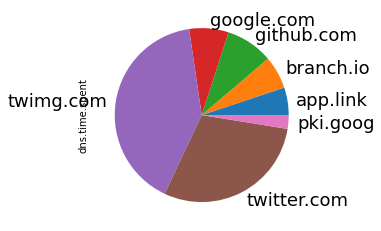

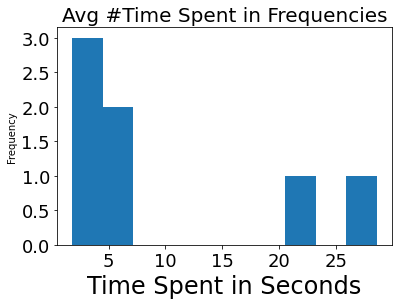

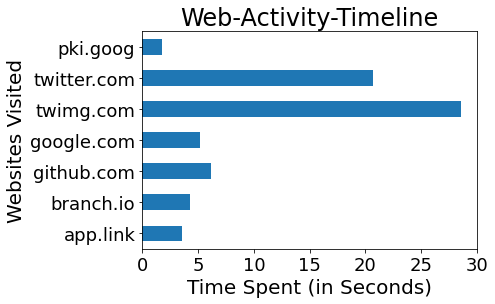

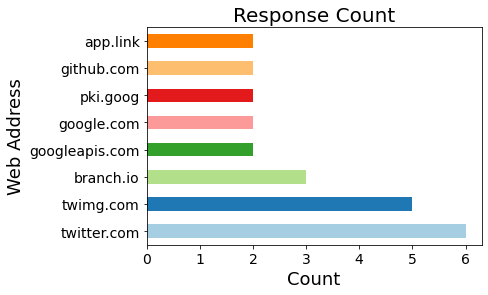

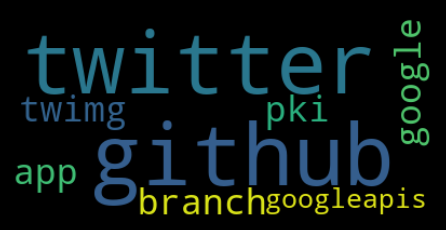

	 ########## Stats About Web-Activity-Timeline ##########
# of Enteries: 12.0
Avergae Time Spent: 25.81 seconds
Max Time spent in sec @ gstatic.com  ::  55.01 seconds 
There are 102 words in the combination of all review.


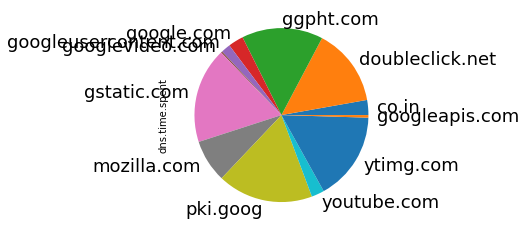

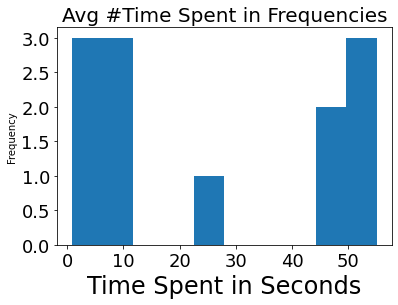

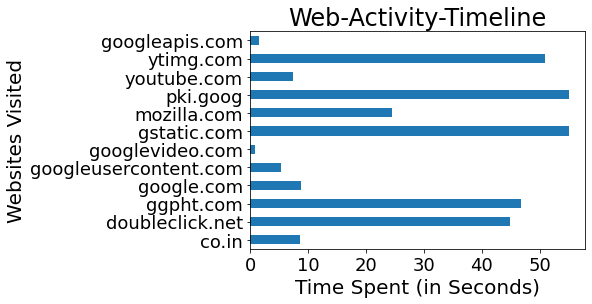

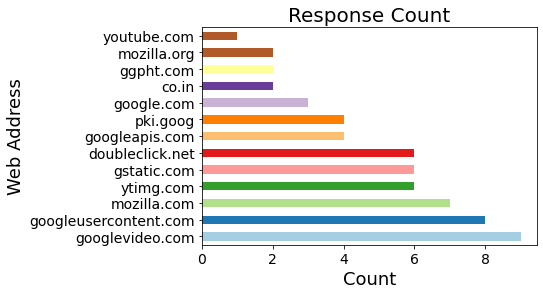

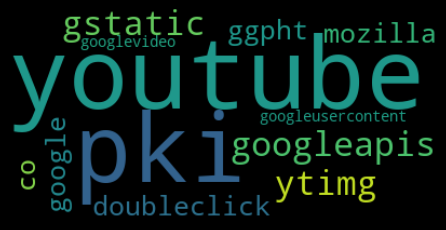

	 ########## Stats About Web-Activity-Timeline ##########
# of Enteries: 15.0
Avergae Time Spent: 18.68 seconds
Max Time spent in sec @ gstatic.com  ::  59.4 seconds 
There are 177 words in the combination of all review.


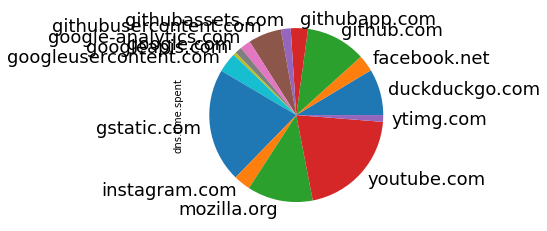

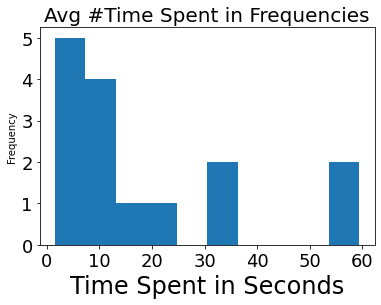

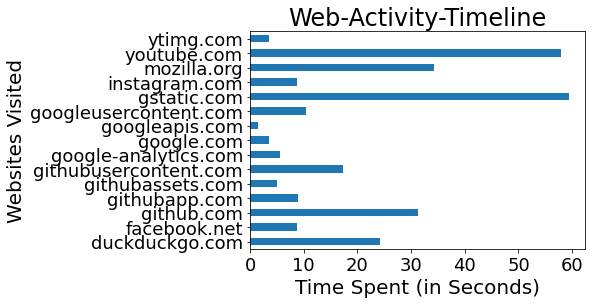

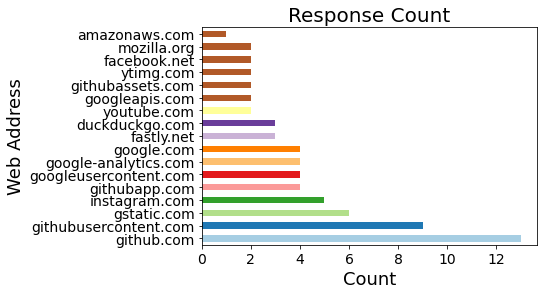

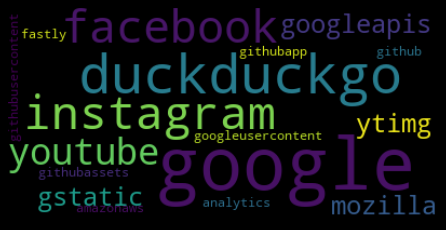

In [25]:
paths = read_all_pcaps('/home/bajaj-debian/networkTrafficAnalysis/nta/')

# Pcap Analysis
<br>
<img src="images_in/pcap_analysis.png" />

In [26]:
#df_dns_init = execute_pcapng_dns_analysis(paths[0])
#df_test_records = get_df_from_records(records)

In [27]:
    #2. General Stats
    #print_web_timeline_activity_stats(df_test_records)
    
    #3. Pie Chart
    #plot_pie_chart(df_test_records)

In [28]:
    #4. Plot Barh  and Plot hist and Plot visits count
    #plot_histgram(df_test_records)
    #plot_bar_graph(df_test_records)

In [29]:
    #Plot visits count
    #plot_visits_count(df_dns_init)

In [30]:
    #word_cloud
    #show_word_cloud(name_count)
    #create_profile
    #create_profile(df_dns_init)

# Compare Profiles and Genrate Comparison Table

In [31]:
compare_profiles()

In [32]:
print_match_no_match_table()

+------------------+---------+----------+---------+------------+---------------------+---------+
| Profile_cmp_with | VC_perc | DTC_perc | NC_perc | Match_perc | Profile_cmp_against |  Status |
+------------------+---------+----------+---------+------------+---------------------+---------+
|        0         |   0.0   |   0.0    |   0.0   |    0.0     |          1          | NoMatch |
|        0         |   12.5  |   0.0    |   12.5  |    8.33    |          2          |  Match  |
|        1         |   0.0   |   0.0    |   0.0   |    0.0     |          0          | NoMatch |
|        1         |  15.38  |   0.0    |   8.33  |    7.9     |          2          |  Match  |
|        2         |   5.88  |   0.0    |   5.88  |    3.92    |          0          |  Match  |
|        2         |  11.76  |   0.0    |   5.88  |    5.88    |          1          |  Match  |
+------------------+---------+----------+---------+------------+---------------------+---------+
